# Online EM (v1.2)

## Test data

{0: 20, 1: 11, 2: 21, 3: 18, 4: 30}


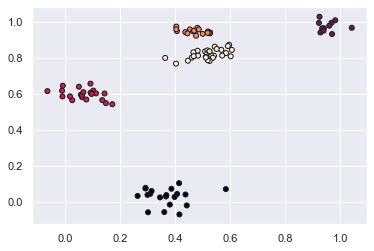

In [20]:
from kuberspatiotemporal.tools import make_gmm

n_clusters=5
X,y = make_gmm(100, n_clusters=n_clusters)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

## Formulas

First implementation following the notation in the paper.

**TODO:** 
* See how the update functions relate to the "standard" maximization step
* Try to have only one implementation
* Check how incremental performs vs batch (if not in the paper already)

$$ \begin{array}{rcll}
S(x,y) &=& \big(\underbrace{\delta_1(x), \ldots, \delta_k(x)}_{=:a_{1:k}}, \underbrace{y\delta_1(x), \ldots, y\delta_k(x)}_{=:b_{1:k}}, \underbrace{yy^T\delta_1(x), \ldots, yy^T\delta_k(x)}_{=:c_{1:k}} \big)\\
S^{(t)} &=& (1-\gamma_t)S^{(t-1)} + \gamma_t \mathbb E\left(S(x,y)|y_t,\Phi^{(t-1}\right) \\
\gamma_t &=& t^{-\alpha}, & 0.5<\alpha<1.0 \text{ (in practice) }\\
\\
a_i^{(t)} &=& (1-\gamma_t)a_i^{(t-1)} + \gamma_t  \text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
b_i^{(t)} &=& (1-\gamma_t)b_i^{(t-1)} + \gamma_t y_t \text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
c_i^{(t)} &=& (1-\gamma_t)c_i^{(t-1)} + \gamma_t y_ty_t^T\text{Pr}(x_t=i | y_t, \Phi^{(j-1)}) \\
\\
\end{array}$$
$$ \begin{array}{rcll}
\pi^{(t)} &=& \frac{\sum^t_{t=1} \mathbb E[S_i^{(t)}(x_t, y_t)|y_{1:T},\Phi^{(j-1)}]} {T} \\
          &=& \frac{\sum^t_{t=1} \mathbb E[(1-\gamma_t)a_i^{(t-1)} + \gamma_t  \text{Pr}(x_t=i | y_t, \Phi^{(j-1)})|y_{1:T},\Phi^{(j-1)}]} {T}  \\
          &=&   \\
          &=&   \\
          &=&   \\
          &=& \frac{a_i^{(t)}}{\sum_{j=1}^k a_j^{(t)}} \\
m^{(t)} &=& \frac{b_i^{(t)}}{a_i^{(t)}} \\
\Sigma^{(t)} &=& \frac{c_i^{(t)}}{a_i^{(t)}} - m_i^{(t)} m_i^{(t)T}  \\
\end{array}$$

The batch EM can also be formulated in terms of the sufficient statistics ... this implementation does this.

Text(0.5, 1.0, 'Learn rate $\\gamma_t$')

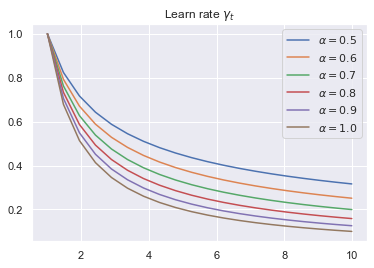

In [6]:
import seaborn as sns

from matplotlib import pyplot as plt
sns.set()

import numpy as np
%matplotlib inline

x = np.linspace(1,10,20)
plt.plot(x, x**(-0.5),label="$\\alpha=0.5$")
plt.plot(x, x**(-0.6),label="$\\alpha=0.6$")
plt.plot(x, x**(-0.7),label="$\\alpha=0.7$")
plt.plot(x, x**(-0.8),label="$\\alpha=0.8$")
plt.plot(x, x**(-0.9),label="$\\alpha=0.9$")
plt.plot(x, x**(-1.0),label="$\\alpha=1.0$")
plt.legend()
plt.title('Learn rate $\\gamma_t$')

In [130]:
from typing import List
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys

from kuberspatiotemporal.tools import check_spd, make_ellipses

%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s')
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)

#######################
# Additions to tools.py
#######################

def check_singular(x, tol = 1/sys.float_info.epsilon):
    is_singular =  np.linalg.cond(x) > tol
    if is_singular:
        logger.warning("Found singular matrix:\n%s\ncond: %f>%f",
                       x, np.linalg.cond(x), tol)
    return is_singular

def repr_list_ndarray(x: np.ndarray) -> str:
    return f"`list of length {len(x)}, elements of shape {np.asarray(x).shape[1:]}`"

    
##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:
    # public attributes
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=3)
    alpha: float = attr.ib(default=0.75)
    start_maximimization: int = attr.ib(default=5)
        
    # Internal state variables
    counter: int = attr.ib(default=0) # This is intended for resuming
    # TODO consider the model to be numpy arrays instead of lists
    weights: List[float] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}`")
    means: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    covs: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    sufficient_statistics: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
        
    def __attrs_post_init__(self):
        if not self.weights:
            rand = np.random.random((self.n_components,))
            self.weights = (rand / np.sum(rand)).tolist()
        if not self.means:
            self.means = [ np.random.random_sample(( self.n_dim,)) 
                          for i in range(self.n_components)]
        if not self.covs:
            self.covs = [ make_spd_matrix(self.n_dim) * 0.01
                         for i in range(self.n_components)]
        # TODO: check if S^(0) can be zero ... actually (1 - 1^{-alpha}) is always! zero!
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components,self.n_dim)),
                np.zeros((self.n_components,self.n_dim,self.n_dim))
            ]
            
    
    # TODO Avoid working with loops. But mvn needs to be rewritten
    def expect(self, data: np.ndarray) -> List[List[float]]:
        """Returns the responsibilities."""

        for i in self.covs:
            if check_singular(i,1e11):
                logger.error('Found singular matrix')
                # raise ArithmeticError(f"Singular covariance matrix:\n{i}")
                # Todo think about how to handle this case.
                
                
        responsibilities = []
        for t in range(data.shape[0]):
            weights = np.asarray(self.weights)
            try:
                denominator = np.sum( [self.weights[i] * mvn.pdf(data[t], 
                                                              self.means[i], 
                                                              self.covs[i]) 
                                       for i in range(self.n_components)] )


                nominators = [self.weights[i] / denominator * mvn.pdf(data[t], 
                                                                   self.means[i], 
                                                                   self.covs[i]) 
                              for i in range(self.n_components)]
            except np.linalg.LinAlgError as e:
                logger.exception("Singular matrix:\n%s,%s,\n%s",
                                 e, [np.linalg.cond(x) for x in self.covs], 
                                 1/sys.float_info.epsilon )

            responsibilities.append(nominators)
        
        return responsibilities 
    
    def maximize(self):
        weights = self.sufficient_statistics[0] / np.sum(self.sufficient_statistics[0])
        means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:,np.newaxis]
        covs = (
            self.sufficient_statistics[2] /  self.sufficient_statistics[0][:,np.newaxis,np.newaxis]
            - np.einsum('ki,kj->kij', means, means)
        )

        logger.debug(weights)
        logger.debug(means)
        logger.debug(covs)

        assert weights.shape == (self.n_components,)
        assert means.shape == (self.n_components, self.n_dim)
        assert covs.shape == (self.n_components, self.n_dim, self.n_dim)

        self.weights = weights.tolist()
        self.means = [i for i in means]
        self.covs = [i for i in covs]


        for i,c in enumerate(self.covs):
            if not check_spd(c):
                logger.info("Sufficient statistics for component %d: %s", i,
                            [j[i] for j in self.sufficient_statistics])
                raise ArithmeticError("Encountered non-SPD matrix")
        
    def batch(self, data: np.ndarray):
        # Compute the sufficient statistics 
        # Instead of regular EM. Then the maximization is the same for batch and incremental
        




        n_samples = data.shape[0]

        responsibilities = np.asarray(self.expect(data)) 
        assert responsibilities.shape == (n_samples, self.n_components)


        self.sufficient_statistics[0] = np.sum(
            responsibilities, # (n_samples, n_components)
            axis=0
        )

        self.sufficient_statistics[1] = np.sum(
            responsibilities[:,:,np.newaxis] * data[:,np.newaxis,:], # (n_samples, n_components, n_dim)
            axis=0
        )

        self.sufficient_statistics[2] = np.sum(
            responsibilities[:,:,np.newaxis,np.newaxis] * 
            np.einsum('Ti,Tj->Tij',data,data)[:,np.newaxis,:,:], # (n_samples, n_components, n_dim, n_dim)
            axis=0
        ) 

        assert self.sufficient_statistics[0].shape == (self.n_components,)
        assert self.sufficient_statistics[1].shape == (self.n_components, self.n_dim)
        assert self.sufficient_statistics[2].shape == (self.n_components, self.n_dim, self.n_dim)

        self.maximize()
        
        self.counter = n_samples
    
    def incremental(self, data: np.ndarray):
        
        
        for t,sample in enumerate(data):
            self.counter += 1
            logger.debug('Observing sample %d\n%s', self.counter, sample)
            
            responsibilities = np.asarray(self.expect(sample.reshape(1,-1))).reshape(-1)

            logger.debug("Resp. %s", responsibilities.shape) # (1, n_components)
            assert responsibilities.shape == (self.n_components,)
        
            rate = (self.counter+1)**(-self.alpha)
            logger.debug('Rate at iteration %d: %f, (1-rate): %f, t: %d, a: %f', t, rate, (1-rate), t, self.alpha)
        
        
            for i in self.sufficient_statistics:
                i *= (1-rate)
            
            self.sufficient_statistics[0] += (
                rate * responsibilities
            )
            
            self.sufficient_statistics[1] += (
                rate * responsibilities[:,np.newaxis] * sample[np.newaxis,:]
            )
            
            self.sufficient_statistics[2] += (
                rate * responsibilities[:,np.newaxis,np.newaxis] * 
                np.einsum('i,j->ij',sample,sample)[np.newaxis,:,:]
            )
            
            logger.debug(self.sufficient_statistics)
            
            assert self.sufficient_statistics[0].shape == (self.n_components,)
            assert self.sufficient_statistics[1].shape == (self.n_components, self.n_dim)
            assert self.sufficient_statistics[2].shape == (self.n_components, self.n_dim, self.n_dim)

            if self.counter > self.start_maximimization:
                self.maximize()

    def fit(self, data: np.ndarray, n_iterations=100, online=False):
        if len(data.shape) != 2:
            raise ValueError(f"Wrong input dimensions (at least 2D)")
            
        if data.shape[1] != self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")

        logger.info("Learning %d samples (%s)", data.shape[0], 
                    "Online" if online else "Batch")

        for i in range(n_iterations):
            if i % 10 == 0:
                logger.info('Step %d/%d', i, n_iterations)
            if online:
                self.incremental(data)
            else:
                self.batch(data)

    def get_logger(self):
        return logger
            
            

### Observation

* If $(1-\gamma_t) = 0$, then $\frac{b_i^{(t)}}{a_i^{(t)}}$ is simply $y_t$! Then all $m_i$ are equal, and the covariances are zero. Which makes sense given that there is only one single point. A sensible starting value has to be found. Also I would love to understand the recursion. Maybe we can solve for the $a,b,c$ given known values of covariances and means (random).
* Need to implement a best-of-n schema in batch. This should then be parallelized and a selection criteria needs to be found. I have high hopes that the nonparametric version will work better (more seeds)
* In case of singularities or not SPD covariance matrices, random initialization should be intended
* Check when singular matrices can occur .. most likely when there are not enough samples per cluster.
* Check out whether the sufficient statistics after learning need to be scaled 

# Batch and incremental

In [139]:
def run_experiment(counter: int, batch_iterations=200, online_iterations=30):
    gmm = GaussianMixtureModel(n_clusters, n_dim=2,start_maximimization=10)
    gmm.get_logger().setLevel(logging.INFO)
    # gmm.get_logger().setLevel(logging.DEBUG)
    np.seterr(all='print') 

    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex='col', sharey='row',figsize=(18, 18))
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18, 18))

    ##########
    # Online 
    
    if counter > 0:
        gmm.fit(X[:counter,:], online=False, n_iterations=batch_iterations)

        make_ellipses(gmm, ax1)

        means = np.asarray(gmm.means)
        ax1.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                    s=50, edgecolor='k')
    ax1.scatter(X[:counter, 0], X[:counter, 1], marker='o', c=y[:counter],
            s=25, edgecolor='k')
    ax1.set_title(f"Batch learning ({batch_iterations} iterations, {counter} samples).")

    ##########
    # Online 

    gmm.get_logger().setLevel(logging.INFO)

    gmm.fit(X[counter:,:],online=True, n_iterations=online_iterations)

    make_ellipses(gmm, ax2)

    ax2.scatter(X[counter:, 0], X[counter:, 1], marker='o', c=y[counter:],
                s=25, edgecolor='k')

    means = np.asarray(gmm.means)
    ax2.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    ax2.set_title(f"Online learning ({batch_iterations} iterations, {X.shape[0]-counter} samples).")
    

    ####################
    # Show all samples

    make_ellipses(gmm, ax3)

    ax3.scatter(X[:, 0], X[:, 1], marker='o', c=y,
                s=25, edgecolor='k')

    means = np.asarray(gmm.means)
    ax3.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    ax3.set_title(f"All data.")
    

[fit:267] Learning 50 samples (Batch)
[fit:271] Step 0/200
[fit:271] Step 10/200
[fit:271] Step 20/200
[fit:271] Step 30/200
[fit:271] Step 40/200
[fit:271] Step 50/200
[fit:271] Step 60/200
[fit:271] Step 70/200
[fit:271] Step 80/200
[fit:271] Step 90/200
[fit:271] Step 100/200
[fit:271] Step 110/200
[fit:271] Step 120/200
[fit:271] Step 130/200
[fit:271] Step 140/200
[fit:271] Step 150/200
[fit:271] Step 160/200
[fit:271] Step 170/200
[fit:271] Step 180/200
[fit:271] Step 190/200
[fit:267] Learning 50 samples (Online)
[fit:271] Step 0/10


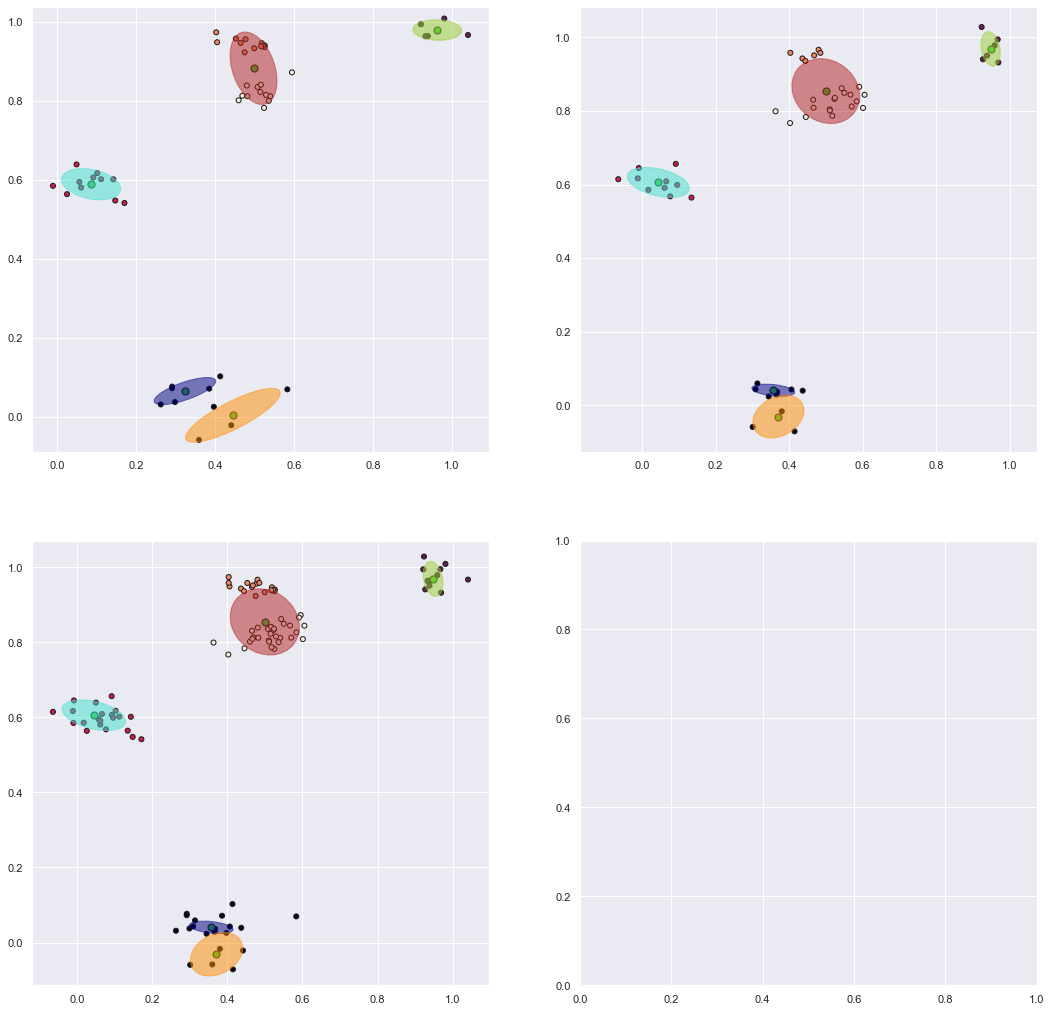

In [116]:
run_experiment(50)

[fit:268] Learning 100 samples (Online)
[fit:272] Step 0/30
[fit:272] Step 10/30
[fit:272] Step 20/30


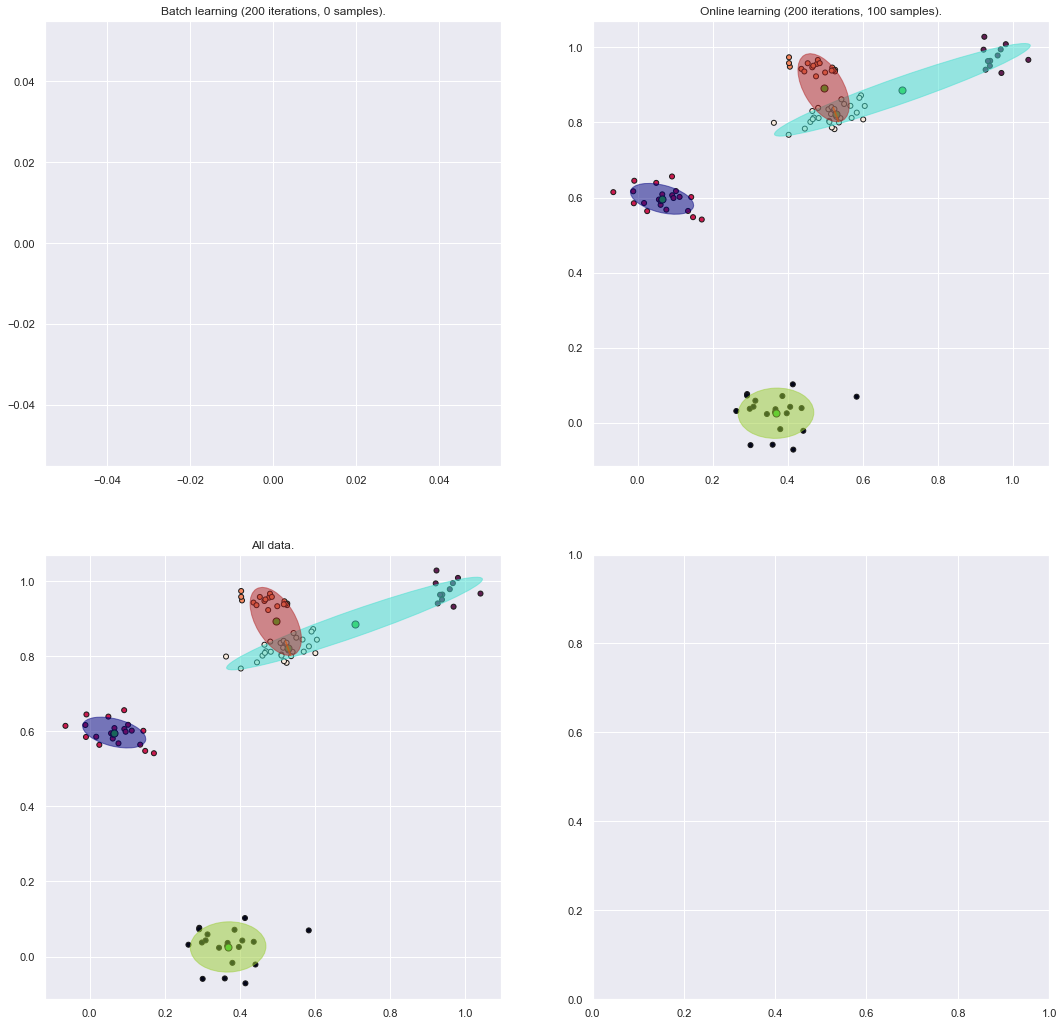

In [140]:
run_experiment(0)